# Loader

Here we prepare a list containing all our slices from all the acquisitions in `spineGeneric_201904271322`


In [1]:
import nibabel as nib
import numpy as np
import json
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
with open('paths.json') as json_data:
    paths_centers = json.load(json_data,)

paths_centers = paths_centers['bids_path']
paths_subjects = []
paths_acq = []

#ds_raw will list all the pixel matrixes from the slices
ds_raw = []
#labels will list all the corresponding contrast labels
labels = []

for center in paths_centers:
    
    sub_list = [sub for sub in os.listdir(center) if "sub" in sub]
    
    for subject in sub_list:
        path_subject = os.path.join(center, subject)        
        
        contrasts_lst = ["_T1w.nii.gz", "_T2w.nii.gz", "_T2star.nii.gz",
                        "_acq-T1w_MTS.nii.gz" , "_acq-MTon_MTS.nii.gz", 
                         "_acq-MToff_MTS.nii.gz"]

        for contrast in contrasts_lst:
            dest = subject + contrast
            path_acq = os.path.join(path_subject, "anat", dest)
            if os.path.exists(path_acq):
                paths_acq.append(path_acq)
                labels.append(contrasts_lst.index(contrast))
                

for acq in tqdm_notebook(paths_acq, unit = "subject"):
    
    slices = nib.load(acq).get_data()
    if slices.size == 0:
        labels.pop(paths_acq.index(acq))
        continue
    #we only take a couple of slices per acquisitions because
    #most are very similar and it would make way too much slices
    for i in range(np.shape(slices)[2]//2 - 1, np.shape(slices)[2]//2 + 1):
        ds_raw.append(slices[:,:,i])

#since we took 2 slices of each acquisition we have to double each label
labels = np.repeat(labels, 2) 
labels = labels.astype(dtype = 'int32')

#at this point ds contains the entire slices

# Preprocessing

Here we pre-process the data to ease the clustering :
- center the images around the regions of interest
- normalize the intensity and brightness of the dataset (?)

In [59]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

#we crop the images
ds_cropped = []
for sl in ds_raw:
    if len(np.shape(sl)) >= 3 :
        sl = sl[:,:,0]
    h,l = np.shape(sl)[0], np.shape(sl)[1]
    ds_cropped.append(sl[h//3:2*h//3,l//3:2*l//3])
    
#for now we do not add any normalization in brightness
ds = []
for sl in ds_cropped:
    ds.append(normalize(sl, norm = 'l2'))

And we add a visualization tool for qc

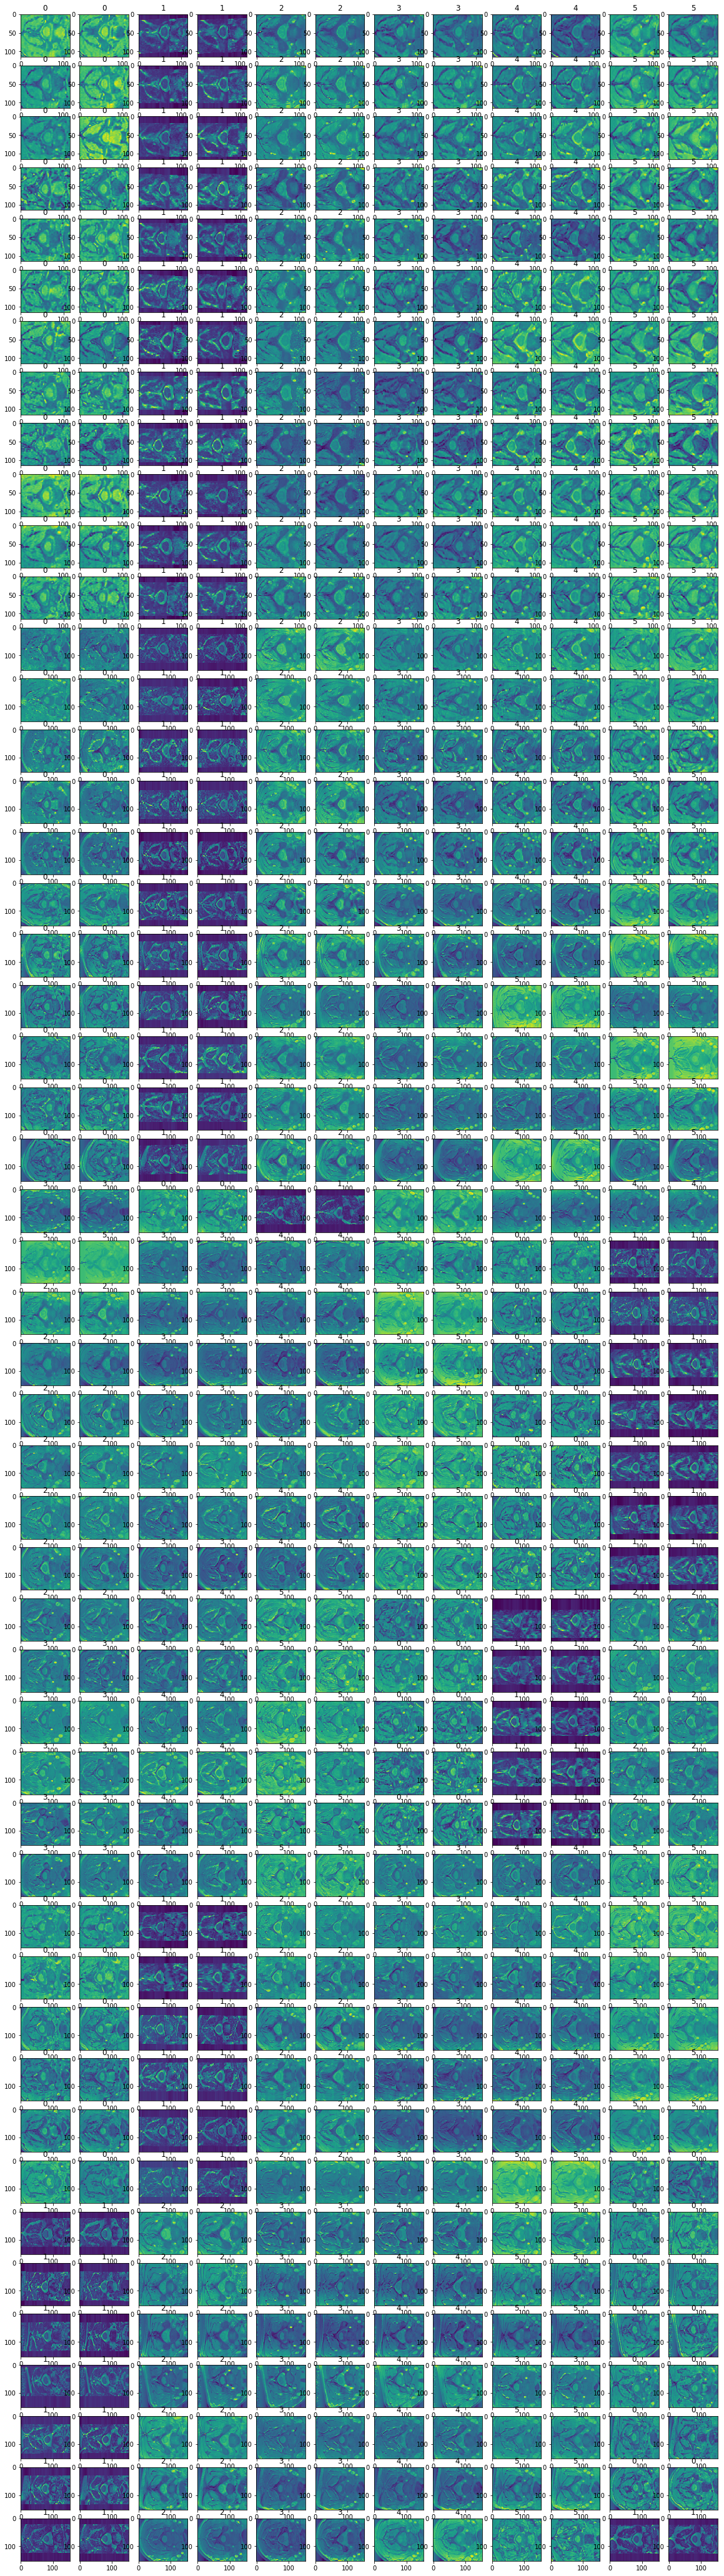

In [50]:
ncols = 12
nrows = 50
i,j = 0,0

fig, axes = plt.subplots(nrows, ncols, figsize = (20, (nrows * 3)//2))

for sl in tqdm_notebook(ds, unit = "slice"):
    axes[i,j].imshow(sl, aspect = 'auto')
    axes[i,j].set_title(labels[i*ncols + j])
    j += 1
    if j >= ncols:
        j = 0
        i += 1
    #we have to stop here because figure size is limited
    if i == nrows:
        break

#this rendering step is a bit long
fig.show()

# Feature Engineering

Here we use a pretrained VGG-16 to extract features of the images and be able to cluster it.

In [73]:
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input

vgg = VGG19(weights='imagenet', include_top=False)
resnet = ResNet50(weights='imagenet', include_top=False)

/home/GRAMES.POLYMTL.CA/p112175/anaconda3/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [83]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns


#we encapsulate the extractor in a function
def extract_features(img, model):
    img_resized = resize(img, (224,224))
    img_3_channels = np.resize(img_resized, (224,224,3))
    img_vect = np.expand_dims(img_3_channels, axis = 0)
    img_in = preprocess_input(img_vect)
    features = model.predict(img_in)
    feat = features[0].flatten()
    return(feat)


features_list = []
#and then we appply it to all the slices
for sl in tqdm_notebook(ds, unit = "slice"):
    features_list.append(np.concatenate((extract_features(sl, resnet),
                                       extract_features(sl, vgg))))
    



# Clusterization

First a t-SNE visualization, then the actual KMeans clustering

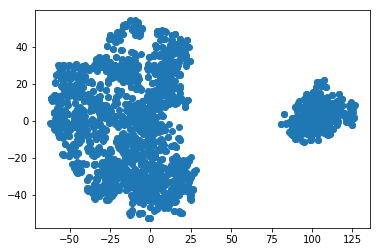

In [84]:
features_list = np.array(features_list)
pca = PCA(n_components = 50).fit(features_list).transform(features_list)
tsne_results = TSNE(n_components = 2, perplexity = 50, n_iter = 5000).fit_transform(pca)
plt.scatter(tsne_results[:,0], tsne_results[:,1])


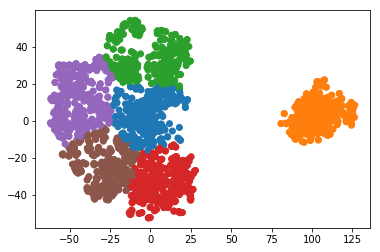

In [85]:
clusters = 6

#pca = PCA(n_components = 40).fit(features_list).transform(features_list)
#tsne_results = TSNE(n_components = 2, perplexity = 30, n_iter = 3000).fit_transform(pca)
k_means = KMeans(n_clusters=clusters, random_state=0).fit(tsne_results)

#generating the color palette
colors = []
palette = sns.color_palette(None, clusters)
for label in k_means.labels_:
    colors.append(palette[label])

#pca_2d = PCA(n_components = 2).fit(features_list).transform(features_list)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors)
plt.show()

Remarques :
- La PCA ne suffit pas à extraire de l'information puisqu'on se retrouve avec une classe énorme (plus de 85% des 
slices) et quelques slices ailleurs.
- PCA + tSNE semble mieux rendre la structure intrinsèque des données.

# Validation and analysis of the different clusters

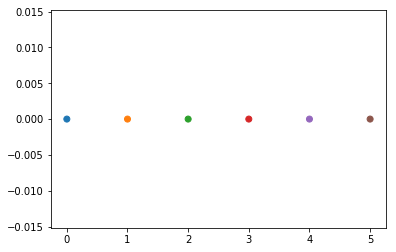

In [86]:
#color to class mapping
plt.scatter([i for i in range(clusters)], [0 for i in range(clusters)], c=palette)
plt.show()

In [87]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, k_means.labels_)

array([[139,  44,   9,  38,  81,  13],
       [  2, 282,  14,   4,  18,   2],
       [ 19,   0, 145,  62,  64,  30],
       [ 41,   0,  68,  82,  66,  97],
       [ 39,   0,  58,  81,  63,  91],
       [ 50,   2,  43,  84,  81,  70]])

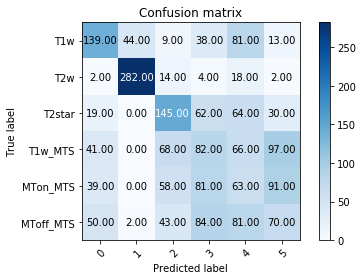

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=[i for i in range(clusters)], yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#plot non-normalized confusion matrix
class_names = ["T1w", "T2w", "T2star", "T1w_MTS" , "MTon_MTS", 
               "MToff_MTS"]
plot_confusion_matrix(labels, k_means.labels_, classes=class_names,
                      title="Confusion matrix")
plt.show()

# TODO

- [ ] Try with ResNet50 and VGG19 instead of VGG16
- [ ] Try with KMeans + MeanShift
- [ ] Add interactive visualization tools to see what is inside the clusters
- [ ] Add intensity normalization in the pre-processing

# Random testing



In [12]:
ex = "../duke/projects/ivado-medical-imaging/spineGeneric_201904271322/result/juntendo-750w_spineGeneric/sub-04/anat/sub-04_T1W.nii.gz"


img = nib.load(ex).get_data()

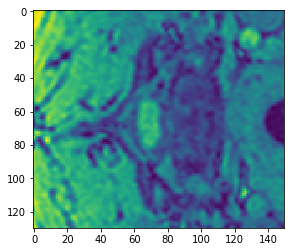

In [62]:
sl = img[110:240,100:250,1]
np.shape(sl)
sl_2 = scale(sl)
sl_3 = normalize(sl, norm='l1')

plt.imshow(sl)